In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme
import geopandas as gpd
import plotly.express as px

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","364,884.83","32,244.38",9.69%
1,4,r,"81,991.16","78,481.14","-3,510.02",-4.28%
2,2,f,"11,349.85","8,710.92","-2,638.93",-23.25%
3,1,c,"6,354.00","4,526.20","-1,827.80",-28.77%
4,3,p,"3,235.36","2,881.85",-353.51,-10.93%
5,Total,Total,"435,570.83","459,484.94","23,914.12",5.49%


In [3]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

,submode,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Link Red Line,"78,765.00","91,203.00","75,221.83",-4.50%,-17.52%
1,Sounder,"6,765.00","7,711.00","4,526.20",-33.09%,-41.30%


### boarding by agency

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [5]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","267,306.59","13,992.97",5.52%
1,5,Sound Transit,"113,374.00","126,059.04","12,685.04",11.19%
2,0,Community Transit,"25,962.00","29,051.47","3,089.47",11.90%
3,4,Pierce Transit,"21,185.00","14,931.84","-6,253.16",-29.52%
4,6,Washington Ferries,"9,278.21","5,607.03","-3,671.18",-39.57%
5,3,Kitsap Transit,"8,258.00","11,447.59","3,189.59",38.62%
6,1,Everett Transit,"4,201.00","5,063.03",862.03,20.52%
7,Total,Total,"435,571.83","459,466.58","23,894.75",5.49%


In [6]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

,agency,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Community Transit,"23,000.00",0.00,"29,051.47",26.31%,-
1,Everett Transit,0.00,0.00,"5,063.03",-,-
2,King County Metro,"244,306.00","272,556.00","267,306.59",9.41%,-1.93%
3,Kitsap Transit,"8,000.00","9,300.00","11,447.59",43.09%,23.09%
4,Pierce Transit,"19,974.00",0.00,"14,931.84",-25.24%,-
5,Sound Transit,"115,516.00","133,703.00","126,059.04",9.13%,-5.72%
6,Washington Ferries,0.00,0.00,"5,607.03",-,-


In [7]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency']).sum()[['observed_boardings','model_boardings']]
df['difference'] = df['model_boardings']-df['observed_boardings']
df['percent diff'] = (df['difference']/df['observed_boardings'])
df[['percent diff']] = df[['percent diff']].applymap(format_percent)
df

# table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
# table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
# table_df.loc['Total','agency'] = 'Total'
# table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
# table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
# table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
# table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
# table_df = table_df.reset_index()
# table_df

,observed_boardings,model_boardings,difference,percent diff
agency,,,,
Community Transit,"25,962.00","29,051.47","3,089.47",11.90%
Everett Transit,"4,201.00","5,063.03",862.03,20.52%
King County Metro,"251,166.45","265,031.47","13,865.02",5.52%
Kitsap Transit,"4,048.00","6,151.21","2,103.21",51.96%
Pierce Transit,"21,185.00","14,931.84","-6,253.16",-29.52%
Sound Transit,"26,079.00","44,637.45","18,558.45",71.16%


### boarding by key route

In [8]:
# df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
# # df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')
# # df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
# # df.drop(['route_code','agency'], axis=1, inplace=True)
# # df
# df_boarding_key
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df[df['mode'].isin(['f','p'])][['description','mode','observed_boardings','model_boardings','diff','perc_diff']]
df

,description,mode,observed_boardings,model_boardings,diff,perc_diff
147,973 W Sea Water Taxi,p,759.00,359.16,-399.84,-0.53
148,975 Vashn Water Taxi,f,338.00,330.21,-7.79,-0.02
270,Seattle-Bremerton FF,f,"1,913.00","3,302.96","1,389.96",0.73
271,Brem-Pt Orchard FF,p,768.00,"1,044.54",276.54,0.36
272,Brem-Annapolis FF,p,469.00,224.74,-244.26,-0.52
273,Seattle-Kingston FF,p,429.00,83.00,-346.00,-0.81
274,Seattle-Southwrth FF,f,631.00,641.13,10.13,0.02
278,WSF Edmonds-Kingston,f,"1,500.13",187.23,"-1,312.90",-0.88
279,WSF Seattle-Bain Isl,f,"5,513.69","3,870.37","-1,643.33",-0.30
280,WSF Seattle-Brem,f,"1,188.97",181.57,"-1,007.40",-0.85


In [9]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff


In [10]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [11]:
# df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
# df['route_code'] = df['route_code'].astype('int')
# df[['route_code','description', '@bvol']]

In [12]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Sounder South,"6,038.00","4,522.00","-1,516.00",-25.11%
1,Sounder North,316.00,4.20,-311.80,-98.67%


r^2 : 1.0


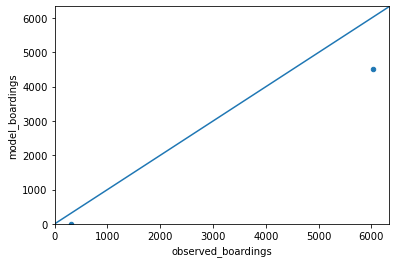

In [13]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [14]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
4,E Line RapidRide,"11,426.00","15,111.03","3,685.03",32.25%
2,C Line RapidRide,"7,250.00","9,657.54","2,407.54",33.21%
3,D Line RapidRide,"9,044.00","7,232.64","-1,811.36",-20.03%
0,A Line RapidRide,"8,412.00","6,855.10","-1,556.90",-18.51%
1,B Line RapidRide,"4,177.00","3,401.24",-775.76,-18.57%


r^2 : 0.8530077868813888


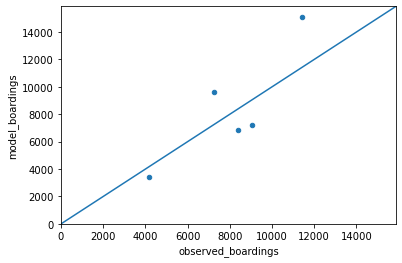

In [15]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [16]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']

In [17]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
130,King County Metro,E-Line,b,"15,111.03","11,426.00","3,685.03",0.32
5,King County Metro,7 Rain Bch-ColC-CBD,b,"10,545.22","9,954.00",591.22,0.06
128,King County Metro,C Line,b,"9,657.54","7,250.00","2,407.54",0.33
28,King County Metro,40 Ngt-Bal-Fre-CBD,b,"8,470.60","7,208.00","1,262.60",0.18
129,King County Metro,D Line,b,"7,232.64","9,044.00","-1,811.36",-0.20
132,King County Metro,H-Line,b,"7,105.82","6,907.00",198.82,0.03
126,King County Metro,A Line,b,"6,855.10","8,412.00","-1,556.90",-0.19
67,King County Metro,160 Aub-Kent-Rent,b,"6,450.95","5,058.00","1,392.95",0.28
64,King County Metro,150 Kent-SC-Tuk-CBD,b,"5,932.55","4,072.00","1,860.55",0.46
39,King County Metro,62 SndPt-GLk-Fre-CBD,b,"5,891.15","5,899.00",-7.85,-0.00


In [18]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
309,Sound Transit,Light Rail Ang Lk-NG,r,"75,221.83","79,522.00","-4,300.17",-0.05
293,Sound Transit,550 Bellevue-Seattle,b,"7,744.78","3,351.00","4,393.78",1.31
292,Sound Transit,545 Redmond-Seattle,b,"5,230.03","3,340.00","1,890.03",0.57
294,Sound Transit,554 Issaquah-Seattle,b,"5,160.60","2,153.00","3,007.60",1.40
286,Sound Transit,512 Everett-Northgte,b,"5,117.50","2,251.00","2,866.50",1.27
310,Sound Transit,Commutr Rail Tac-Sea,c,"4,522.00","6,038.00","-1,516.00",-0.25
288,Sound Transit,522 Woodinvl-Roosvlt,b,"4,428.93","1,736.00","2,692.93",1.55
300,Sound Transit,578 Seattle-Puyallup,b,"2,970.73","1,460.00","1,510.73",1.03
296,Sound Transit,560 W Sea-Bellevue,b,"2,312.03","1,227.00","1,085.03",0.88
290,Sound Transit,535 Lynnwood-Bllvue,b,"2,286.12","1,226.00","1,060.12",0.86


In [19]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
230,Community Transit,Swift Blue,b,"6,193.66","3,804.00","2,389.66",0.63
231,Community Transit,Swift Green,b,"3,033.81","3,000.00",33.81,0.01
200,Community Transit,116 Edm-Silver Firs,b,"2,238.77",955.00,"1,283.77",1.34
199,Community Transit,115 McClm P&R-AurVil,b,"1,764.63","1,133.00",631.63,0.56
206,Community Transit,202 Smokey Pt-Lynnwd,b,"1,613.86","1,002.00",611.86,0.61
205,Community Transit,201 Smokey Pt-Lynnwd,b,"1,599.68","1,049.00",550.68,0.52
191,Community Transit,101 Mar P&R-Aur Vill,b,"1,438.15",945.00,493.15,0.52
203,Community Transit,130 Edmonds-Lynnwood,b,932.64,618.00,314.64,0.51
198,Community Transit,113 Mukilteo-Lynn TC,b,854.30,802.00,52.30,0.07
216,Community Transit,280 Gran Falls-Evrt,b,741.19,335.00,406.19,1.21


In [20]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
160,Pierce Transit,1 6th Ave-Pac Ave,b,"1,580.72","3,035.00","-1,454.28",-0.48
184,Pierce Transit,400 Puyllp-Tacoma,b,"1,162.35",336.00,826.35,2.46
185,Pierce Transit,402 Meridian,b,"1,129.00",626.00,503.00,0.80
161,Pierce Transit,2 S 19th-Bridgeport,b,"1,074.10","1,729.00",-654.90,-0.38
189,Pierce Transit,500 Federal Way,b,"1,029.61",845.00,184.61,0.22
169,Pierce Transit,41 S 56th St-Salish,b,917.73,"1,088.00",-170.27,-0.16
190,Pierce Transit,501 Miltn-Fed Way,b,895.45,431.00,464.45,1.08
162,Pierce Transit,3 Lakewood-Tacoma,b,854.77,"1,250.00",-395.23,-0.32
163,Pierce Transit,4 Lakewd-South Hill,b,736.26,968.00,-231.74,-0.24
177,Pierce Transit,57 Union-19th-Hilltp,b,491.61,864.00,-372.39,-0.43


In [21]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
270,Kitsap Transit,Seattle-Bremerton FF,f,"3,302.96","1,913.00","1,389.96",0.73
271,Kitsap Transit,Brem-Pt Orchard FF,p,"1,044.54",768.00,276.54,0.36
244,Kitsap Transit,217 Brem-Silverdle E,b,"1,009.66",417.00,592.66,1.42
242,Kitsap Transit,212 Brem-Silverdle W,b,764.36,679.00,85.36,0.13
274,Kitsap Transit,Seattle-Southwrth FF,f,641.13,631.00,10.13,0.02
259,Kitsap Transit,86 Southwrth Shuttle,b,625.60,91.00,534.60,5.87
260,Kitsap Transit,390 Poulsbo-Bainbrdg,b,541.85,170.00,371.85,2.19
243,Kitsap Transit,215 McWilliams,b,341.21,115.00,226.21,1.97
240,Kitsap Transit,8 Bethel,b,266.04,152.00,114.04,0.75
254,Kitsap Transit,333 Silvrdale-Bainb,b,232.73,114.00,118.73,1.04


In [22]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
316,Everett Transit,7 Coll Stn-Mall Stn,b,"2,782.08","2,239.00",543.08,0.24
320,Everett Transit,29 Coll Stn-Mall Stn,b,"1,389.77",881.00,508.77,0.58
313,Everett Transit,3 Seaway TC-Evt Stn,b,353.60,285.00,68.60,0.24
317,Everett Transit,8 Airport Rd-Evt Stn,b,128.85,156.00,-27.15,-0.17
315,Everett Transit,6 Waterfront-Evt Stn,b,93.89,62.00,31.89,0.51
312,Everett Transit,2 Marnr P&R-Mall Stn,b,91.10,148.00,-56.90,-0.38
314,Everett Transit,4 Evt Stn-Collge Stn,b,82.75,114.00,-31.25,-0.27
319,Everett Transit,18 Mukilteo-Evt Stn,b,74.10,60.00,14.10,0.23
318,Everett Transit,12 Mall Stn-Seawy TC,b,66.88,256.00,-189.12,-0.74


### boarding on lines by agency

r^2 Community Transit: 0.9162510868013095
r^2 Everett Transit: 0.9892348622858667
r^2 King County Metro: 0.9442343545207805
r^2 Kitsap Transit: 0.9283753221722526
r^2 Pierce Transit: 0.6936757555433636


r^2 Sound Transit: 0.9956625872380672
r^2 Washington Ferries: 0.9443804108096565


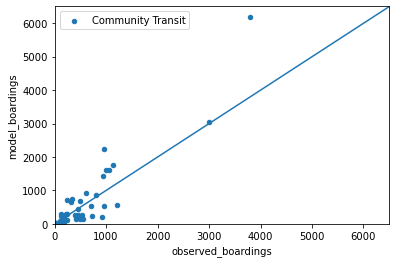

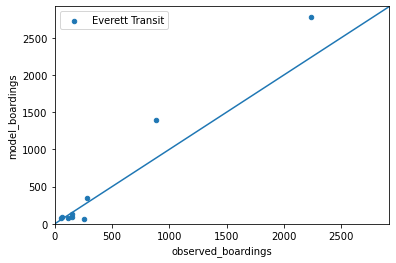

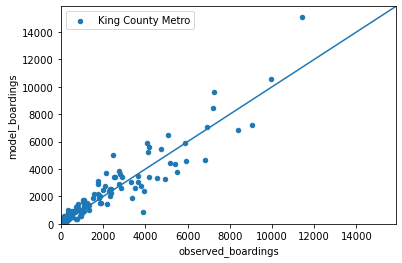

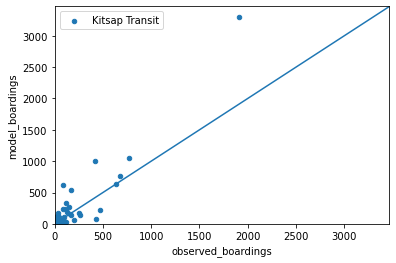

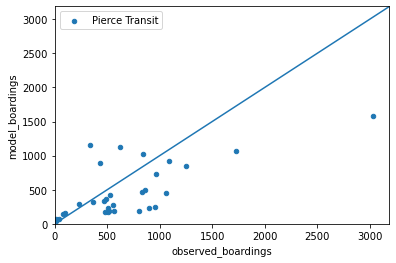

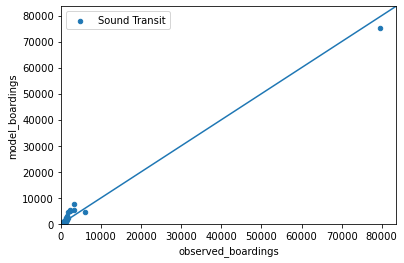

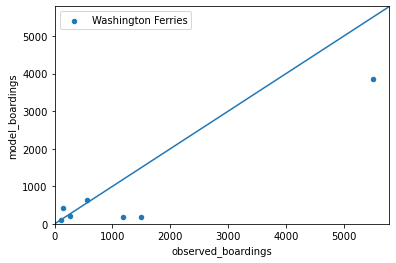

In [23]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [24]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"4,821.00","3,178.64","-1,642.36",-34.07%
Westlake,"9,739.00","9,348.43",-390.57,-4.01%
Symphony,"4,263.00","5,350.97","1,087.97",25.52%
Pioneer Square,"2,664.00","5,000.67","2,336.67",87.71%
Int'l District,"4,797.00","1,842.64","-2,954.36",-61.59%
Capitol Hill,"7,263.00","7,074.52",-188.48,-2.60%
Stadium,"2,320.00",313.38,"-2,006.62",-86.49%
SODO,"1,652.00","2,263.13",611.13,36.99%
Beacon Hill,"2,211.00","1,289.81",-921.19,-41.66%


In [25]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"4,821.00","3,178.64","-1,642.36",-34.07%
Capitol Hill,"7,263.00","7,074.52",-188.48,-2.60%
Westlake/Symphony,"14,002.00","14,699.40",697.40,4.98%
Pioneer Square/Int'l District,"7,461.00","6,843.31",-617.69,-8.28%
Stadium/SODO,"3,972.00","2,576.51","-1,395.49",-35.13%
Beacon Hill/Mount Baker,"4,269.00","2,938.22","-1,330.78",-31.17%
Columbia City,"1,840.00","1,578.54",-261.46,-14.21%
Othello/Rainier Beach,"3,486.00","3,484.78",-1.22,-0.04%
Tukwila Int'l Blvd,"2,423.00","2,644.55",221.55,9.14%


In [26]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df

,model_boardings,2023,2024
station_name,,,
Angle Lake,"2,496.48","3,840.00","5,093.00"
Beacon Hill,"1,289.81","2,211.00","2,672.00"
Capitol Hill,"7,074.52","7,263.00","8,207.00"
Columbia City,"1,578.54","1,840.00","2,145.00"
Husky Stadium,"3,178.64","4,821.00","5,122.00"
Int'l District,"1,842.64","4,797.00","5,372.00"
Mount Baker,"1,648.41","2,058.00","2,458.00"
Northgate Station,"8,097.68","10,430.00","4,150.00"
Othello,"1,969.10","2,083.00","2,466.00"


## light rail stop transfers

In [27]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.81,-99.00,99.81,-100.81%
Westlake,0.12,0.36,-0.24,-66.00%
Symphony,0.31,0.20,0.11,57.27%
Pioneer Square,0.39,0.16,0.23,142.33%
Int'l District,0.51,0.45,0.06,13.82%
Capitol Hill,0.06,-99.00,99.06,-100.06%
Stadium,0.35,0.12,0.23,195.38%
SODO,0.65,0.31,0.34,107.26%
Beacon Hill,0.34,0.35,-0.02,-4.42%


## Park and Ride

In [28]:
df = pd.read_csv(r'C:\Workspace\sc_2023_01_30_25\outputs\daysim\_trip.tsv', sep='\t')
pnr_boardings = df[(df['otaz'].isin(range(3750,4001))) & (df['mode']==6)]
pnr_boardings = pnr_boardings.groupby('otaz').count()[['trexpfac']].reset_index()

In [29]:
stations = [
    {"id": 3751, "name": "Tukwila Station (CR)"},
    {"id": 3752, "name": "Tacoma Dome Station"},
    {"id": 3753, "name": "South Tacoma (CR)"},
    {"id": 3754, "name": "Everett Station (CR)"},
    {"id": 3755, "name": "Sumner Station (CR)"},
    {"id": 3756, "name": "Mukilteo Station"},
    {"id": 3757, "name": "Kent Station (CR)"},
    {"id": 3758, "name": "Auburn Station (CR)"},
    {"id": 3759, "name": "Lakewood (CR)"},
    {"id": 3760, "name": "Gateway P&R"},
    {"id": 3761, "name": "Puyallup Station (SB)"},
    {"id": 3762, "name": "Twin Lakes P&R"},
    {"id": 3763, "name": "Crossroads Neighborhood Church"},
    {"id": 3764, "name": "Overlake Transit Center"},
    {"id": 3765, "name": "Redondo Heights P&R"},
    {"id": 3766, "name": "North Gig Harbor/Kimball Drive"},
    {"id": 3767, "name": "Duvall P&R"},
    {"id": 3768, "name": "Roy 'Y' P&R"},
    {"id": 3769, "name": "South Hill (Elim Evangelical)"},
    {"id": 3770, "name": "Parkland Transit Center"},
    {"id": 3771, "name": "SR-512/I-5 (Lakewood)"},
    {"id": 3772, "name": "Center Street P&R"},
    {"id": 3773, "name": "Tacoma Mall Transit Center"},
    {"id": 3774, "name": "South Tacoma West"},
    {"id": 3775, "name": "South Tacoma East - 2"},
    {"id": 3776, "name": "Narrows P&R"},
    {"id": 3777, "name": "North Purdy/Purdy Crescent"},
    {"id": 3778, "name": "Point Defiance Ferry"},
    {"id": 3779, "name": "South Federal P&R"},
    {"id": 3780, "name": "Sultan P&R"},
    {"id": 3781, "name": "Federal Way P&R (320th)"},
    {"id": 3782, "name": "Auburn P&R"},
    {"id": 3783, "name": "Star Lake P&R"},
    {"id": 3784, "name": "Holy Spirit Lutheran Church"},
    {"id": 3785, "name": "Kent/Des Moines P&R"},
    {"id": 3786, "name": "Kent/James St. P&R"},
    {"id": 3787, "name": "Burien Transit Center"},
    {"id": 3788, "name": "Tukwila"},
    {"id": 3789, "name": "Maple Valley P&R"},
    {"id": 3790, "name": "South Renton P&R"},
    {"id": 3791, "name": "Renton Highlands P&R (St. Matts)"},
    {"id": 3792, "name": "Issaquah Transit Center"},
    {"id": 3793, "name": "Mercer Island P&R"},
    {"id": 3794, "name": "Mercer Island Presbyterian"},
    {"id": 3795, "name": "Newport Hills P&R"},
    {"id": 3796, "name": "Newport Hills Community Church"},
    {"id": 3797, "name": "Newport Covenant Church"},
    {"id": 3798, "name": "South Bellevue P&R"},
    {"id": 3799, "name": "Wilburton"},
    {"id": 3800, "name": "Eastgate P&R"},
    {"id": 3801, "name": "North Bend P&R"},
    {"id": 3802, "name": "Evergreen Point P&R"},
    {"id": 3803, "name": "Grace Lutheran Church"},
    {"id": 3804, "name": "South Kirkland P&R"},
    {"id": 3805, "name": "Overlake P&R"},
    {"id": 3806, "name": "Houghton P&R"},
    {"id": 3807, "name": "Bethel Lutheran"},
    {"id": 3808, "name": "Redmond P&R"},
    {"id": 3809, "name": "Saint Thomas Episcopal"},
    {"id": 3810, "name": "Valley Center"},
    {"id": 3811, "name": "Bear Creek P&R"},
    {"id": 3812, "name": "Kingsgate P&R"},
    {"id": 3813, "name": "Brickyard P&R"},
    {"id": 3814, "name": "Northshore P&R"},
    {"id": 3815, "name": "Kenmore P&R"},
    {"id": 3816, "name": "Bethany Bible Church"},
    {"id": 3817, "name": "Bothell P&R"},
    {"id": 3818, "name": "Woodinville P&R"},
    {"id": 3819, "name": "Olson & Meyers"},
    {"id": 3820, "name": "Spokane Street P&R"},
    {"id": 3821, "name": "Greenlake P&R"},
    {"id": 3822, "name": "Northgate TC"},
    {"id": 3823, "name": "North Jackson Park"},
    {"id": 3824, "name": "Shoreline"},
    {"id": 3825, "name": "112th St. & I-5"},
    {"id": 3826, "name": "Ober Park"},
    {"id": 3827, "name": "Vashon Heights"},
    {"id": 3828, "name": "Mountlake Terrace P&R"},
    {"id": 3829, "name": "Bethesda Lutheran"},
    {"id": 3830, "name": "Edmonds Station"},
    {"id": 3831, "name": "Edmonds P&R"},
    {"id": 3832, "name": "Lynnwood P&R"},
    {"id": 3833, "name": "Swamp Creek P&R"},
    {"id": 3834, "name": "Mariner P&R"},
    {"id": 3835, "name": "Snohomish"},
    {"id": 3836, "name": "Marysville - Ash Ave"},
    {"id": 3837, "name": "116th & I-5 - Marysville"},
    {"id": 3838, "name": "SR-531 - Marysville"},
    {"id": 3839, "name": "Arlington P&R"},
    {"id": 3840, "name": "Stanwood"},
    {"id": 3841, "name": "Monroe"},
    {"id": 3842, "name": "Federal Way"},
    {"id": 3843, "name": "Port Orchard Armory"},
    {"id": 3844, "name": "Southworth Ferry P&R"},
    {"id": 3845, "name": "McWilliams P&R"},
    {"id": 3846, "name": "Bethany Lutheran Church"},
    {"id": 3847, "name": "Gateway Fellowship"},
    {"id": 3848, "name": "Agate Pass P&R/Clearwater"},
    {"id": 3849, "name": "Kingston Ferry P&R"},
    {"id": 3850, "name": "Suquamish United Church of Christ"},
    {"id": 3851, "name": "Bainbridge Island Ferry"},
    {"id": 3852, "name": "Puyallup Station (NB)"},
    {"id": 3853, "name": "72nd Street Transit Center"},
    {"id": 3855, "name": "DuPont"},
    {"id": 3856, "name": "Aurora Village TC"},
    {"id": 3857, "name": "Aurora Nazarene"},
    {"id": 3858, "name": "Saint Margaret's Episcopal"},
    {"id": 3861, "name": "Lake Meridian P&R"},
    {"id": 3862, "name": "Smokey Pt. Church"},
    {"id": 3863, "name": "Eastmont P&R"},
    {"id": 3864, "name": "McCollum Park P&R"},
    {"id": 3865, "name": "Canyon Park P&R"},
    {"id": 3866, "name": "Korean Presby. P&R"},
    {"id": 3867, "name": "Georges Kountry Korner"},
    {"id": 3868, "name": "Poulsbo Church of the Nazarene"},
    {"id": 3870, "name": "Harper Evangelical Free Church"},
    {"id": 3871, "name": "Mullenix Road"},
    {"id": 3873, "name": "TCC P&R"},
    {"id": 3874, "name": "Ash Way P&R"},
    {"id": 3875, "name": "Bonney Lake P&R"},
    {"id": 3876, "name": "Tukwila Int. Station"},
    {"id": 3877, "name": "South Hill P&R"},
    {"id": 3878, "name": "South Tacoma East - 1"},
    {"id": 3879, "name": "Issaquah Highlands"},
    {"id": 3880, "name": "Lake Stevens TC"},
    {"id": 3881, "name": "Liberty Bay Presbyterian"},
    {"id": 3882, "name": "NK Baptist"},
    {"id": 3883, "name": "Preston P&R"},
    {"id": 3884, "name": "Bayside Community Church"},
    {"id": 3885, "name": "Ollala Valley Fire Station"},
    {"id": 3886, "name": "Bremerton Ferry"},
    {"id": 3888, "name": "Puyallup Fair's Red Lot"},
    {"id": 3889, "name": "Marysville - Cedar & Grove"},
    {"id": 3890, "name": "Stanwood II"},
    {"id": 3891, "name": "Marysville I P&R"},
    {"id": 3892, "name": "Martha Lake Covenant Church"},
    {"id": 3893, "name": "South Sammammish P&R"},
    {"id": 3894, "name": "Renton City Municipal Garage"},
    {"id": 3895, "name": "Tibbetts Lot"},
    {"id": 3896, "name": "Renton Transit Center"},
    {"id": 3897, "name": "Calvary Christian Assembly"},
    {"id": 3898, "name": "Maple Valley Town Square"},
    {"id": 3899, "name": "All Saints Lutheran Church"},
    {"id": 3900, "name": "City View Church"},
    {"id": 3901, "name": "Northwest University 6710 Bldg."},
    {"id": 3902, "name": "Sammamish Lutheran P&R"},
    {"id": 3903, "name": "Redmond Ridge P&R"},
    {"id": 3904, "name": "Kennydale United Methodist Church"},
    {"id": 3905, "name": "Nativity Lutheran Church"},
    {"id": 3906, "name": "South Jackson P&R"},
    {"id": 3907, "name": "South SeaTac (LR)"},
    {"id": 3908, "name": "Everett Station"},
    {"id": 3909, "name": "Bremerton (SR-303/Riddell Road)"},
    {"id": 3910, "name": "Silverdale"},
    {"id": 3911, "name": "Tukwila Station (CR)"},
    {"id": 3913, "name": "Sumner Station Garage"},
    {"id": 3914, "name": "Tacoma Dome"},
    {"id": 3915, "name": "Bothell (SR-527/185th Street)"},
    {"id": 3916, "name": "SR-3/SR-303"},
    {"id": 3917, "name": "SR-16/SR-160"},
    {"id": 3918, "name": "I-5 & 175th"}
]

In [30]:
pnr_capacity = pd.read_csv(r'C:\Workspace\sc_2023_01_30_25\inputs\scenario\networks\p_r_nodes.csv')
df = pnr_capacity.merge(pnr_boardings, left_on='ZoneID', right_on='otaz')
df.rename(columns={'ZoneID': 'taz', 'trexpfac': 'Model Boardings'}, inplace=True)
df['Boardings/Capacity'] = df['Model Boardings']/df['Capacity']
df.head()

,NodeID,taz,XCoord,YCoord,Capacity,Cost,otaz,Model Boardings,Boardings/Capacity
0,3719,3751,"1,292,102.12","170,904.47",390,0,3751,359,0.92
1,3720,3752,"1,244,894.82","91,851.41",2337,0,3752,751,0.32
2,3721,3753,"1,229,573.94","78,529.59",220,0,3753,14,0.06
3,3722,3754,"1,306,255.47","358,805.35",1107,0,3754,454,0.41
4,3723,3755,"1,289,549.88","76,554.53",350,0,3755,142,0.41


In [31]:
df_station_names = pd.DataFrame(stations)
df = df.merge(df_station_names, how='left', left_on='taz', right_on='id')

In [32]:
# df

In [33]:
df['color'] = np.where(df['Boardings/Capacity'] > 1, 'Boardings/Capacity > 1', 'Boardings/Capacity <= 1')

fig = px.scatter(df, y='Model Boardings', x='Capacity', title='Model Boardings vs Capacity',
                 hover_data={'name': True, 'Model Boardings': True, 'Capacity': True, 'Boardings/Capacity': ':.2f'},
                 color='color')
fig.update_layout(height=600, width=800)
fig.show()

In [34]:


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.XCoord, df.YCoord), crs='EPSG:2285')
gdf.to_crs('EPSG:4326', inplace=True)



In [64]:

fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, color='Boardings/Capacity', 
                        size='Boardings/Capacity', hover_data=['taz','Model Boardings', 'Capacity'], 
                        title='Park and Ride Usage vs Capacity', zoom=7)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()